In [1]:
pip install faiss-cpu --user



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from collections import defaultdict

In [3]:
import pandas as pd

# Load your data
file_path = 'section_3.csv' 
with open(file_path, 'r', encoding='utf-8', errors='replace') as f:
    df = pd.read_csv(f)

# Extract user IDs and text data
user_ids = df['Id']  
text_data1 = df['Please specify your broad areas of interest (keywords only) for the final project (e.g., games, reinforcement learning, computer vision, natural language processing, etc.) in ranked order of preferenc'] 
text_data2 = df['Do you already have one or more specific project ideas? If so, please briefly describe them.�']  # Replace with the actual name of the second text column
text_data2 = text_data2.fillna('')
# Combine the two text columns (you can concatenate them, or choose a different method)
combined_text = text_data1 + " " + text_data2





In [4]:
# Load the BERT model to generate embeddings
model = SentenceTransformer('bert-base-nli-mean-tokens')
embeddings = model.encode(combined_text.tolist(), show_progress_bar=True)

2024-11-12 20:47:23.866348: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-12 20:47:23.894343: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-12 20:47:23.902919: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-12 20:47:23.926119: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-12 20:47:27.854478: W tensorflow/compiler/tf2

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [6]:
import pandas as pd
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer

max_size = 4

# Function to perform clustering using Faiss and explicitly merge small clusters
def faiss_clustering_with_merging(embeddings, max_size=4):
    """
    Perform clustering using Faiss and actively merge small clusters.
    Args:
        embeddings: List of sentence embeddings.
        max_size: Maximum size of each cluster.
    Returns:
        List of clusters with merged small clusters.
    """
    n_samples = len(embeddings)
    embedding_dim = len(embeddings[0])  # Dimensionality of embeddings

    # Build Faiss index
    index = faiss.IndexFlatL2(embedding_dim)  # Using L2 (Euclidean distance)
    index.add(np.array(embeddings))  # Add all embeddings to the index

    # Find clusters using nearest neighbors
    visited = set()
    clusters = []

    for i in range(n_samples):
        if i not in visited:
            # Query nearest neighbors
            distances, neighbors = index.search(np.array([embeddings[i]]), max_size)
            neighbors = neighbors.flatten()
            # Only take unvisited neighbors
            cluster = [n for n in neighbors if n not in visited]
            clusters.append(cluster)
            visited.update(cluster)

    # Step 2: Actively merge small clusters with each other
    final_clusters = []
    small_clusters = [c for c in clusters if len(c) < max_size]
    full_clusters = [c for c in clusters if len(c) == max_size]

    while small_clusters:
        current_cluster = small_clusters.pop(0)

        # Try to merge the current small cluster with another small cluster
        merged = False
        for other_cluster in small_clusters:
            if len(current_cluster) + len(other_cluster) <= max_size:
                current_cluster.extend(other_cluster)
                small_clusters.remove(other_cluster)  # Remove the merged cluster
                merged = True
                break

        # If merged successfully or couldn't be merged further, add it to final clusters
        if len(current_cluster) <= max_size:
            final_clusters.append(current_cluster)
        else:
            # If merging exceeded the size limit, split and handle separately
            final_clusters.append(current_cluster[:max_size])
            remaining_part = current_cluster[max_size:]
            small_clusters.insert(0, remaining_part)  # Re-add remaining part as a new cluster

    final_clusters.extend(full_clusters)  # Add the already full clusters

    return final_clusters

# Perform clustering using Faiss with active merging
clusters = faiss_clustering_with_merging(embeddings, max_size=max_size)

# Debug: Print cluster sizes
print(f"Generated {len(clusters)} clusters. Cluster sizes: {[len(c) for c in clusters]}")

# Assign cluster labels to the DataFrame
final_cluster_labels = np.zeros(len(combined_text), dtype=int)

for cluster_id, cluster_items in enumerate(clusters):
    for item in cluster_items:
        final_cluster_labels[item] = cluster_id

# Add the new cluster labels to the DataFrame
df['cluster'] = final_cluster_labels

# Sort the DataFrame by cluster labels
df_sorted = df.sort_values(by='cluster')

# Save the sorted DataFrame to a new CSV file
df_sorted.to_csv('result_3/faiss_clustered_llm.csv', index=False)

print("Clustering completed with active merging and saved to faiss_clustered_data_with_merging.csv")


Generated 29 clusters. Cluster sizes: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 3, 3, 2, 2, 4, 2, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4]
Clustering completed with active merging and saved to faiss_clustered_data_with_merging.csv


In [7]:
from sklearn.metrics import silhouette_score

# Cell to calculate Silhouette Score

# Ensure embeddings are in numpy format
embeddings_np = np.array(embeddings)

# Compute the Silhouette Score for the clustering
sil_score = silhouette_score(embeddings_np, final_cluster_labels)
print(f"Silhouette Score: {sil_score:.4f}")


Silhouette Score: -0.0415


In [15]:
import numpy as np
from cluster_quality_metrics import (
    within_cluster_sum_of_squares,
    average_pairwise_similarity,
    inter_cluster_distance,
    overall_average_pairwise_similarity,
    plot_wcss,
    plot_cohesion,
    plot_separation
)


WCSS per cluster: {0: 254.18079, 1: 156.16776, 2: 182.57423, 3: 286.97568, 4: 258.63678, 5: 253.2835, 6: 285.4431, 7: 132.2876, 8: 152.55295, 9: 310.93182, 10: 421.66766, 11: 325.84518, 12: 112.63413, 13: 237.815, 14: 164.4922, 15: 195.99097, 16: 84.92471, 17: 399.96777, 18: 71.41396, 19: 0.0, 20: 177.22249, 21: 124.13845, 22: 47.619373, 23: 58.658043, 24: 56.90846, 25: 292.60886, 26: 240.23605, 27: 167.40953, 28: 183.99934}


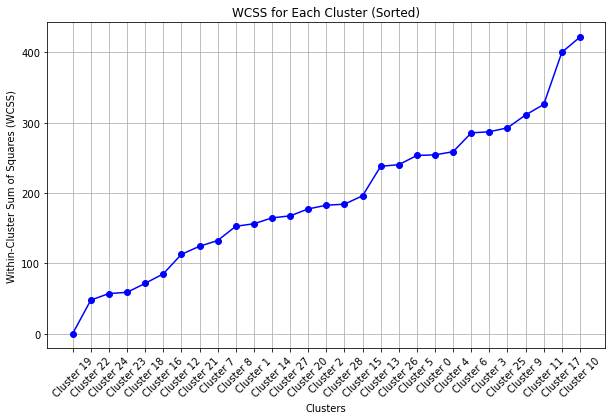

Cohesion per cluster: {0: 0.669591, 1: 0.80632687, 2: 0.7610481, 3: 0.6254788, 4: 0.6578284, 5: 0.65123796, 6: 0.59395695, 7: 0.8337109, 8: 0.80789113, 9: 0.5793857, 10: 0.46038583, 11: 0.5779392, 12: 0.53427553, 13: 0.5304508, 14: 0.6731496, 15: 0.09340189, 16: 0.64781266, 17: 0.4969703, 18: 0.6928848, 19: 1.0, 20: 0.75902826, 21: 0.83666086, 22: 0.9417734, 23: 0.92686415, 24: 0.9291633, 25: 0.6063729, 26: 0.6790724, 27: 0.778061, 28: 0.7277643}


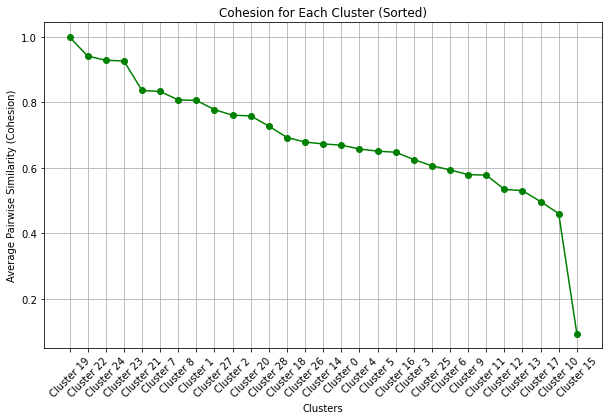

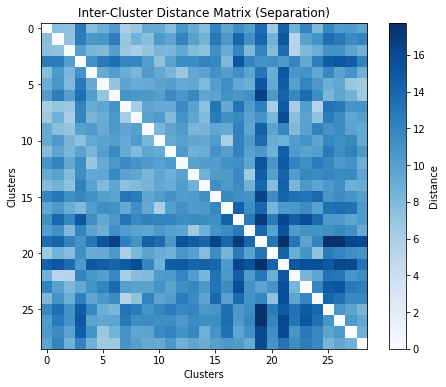

Overall Average Pairwise Similarity: 0.7029453963565995


In [18]:
embeddings_np = np.array(embeddings)
# Calculate WCSS and plot
wcss_per_cluster = within_cluster_sum_of_squares(embeddings_np, clusters)
print("WCSS per cluster:", wcss_per_cluster)
plot_wcss(wcss_per_cluster)


# Calculate Cohesion and plot
cohesion_per_cluster = average_pairwise_similarity(embeddings, clusters)
print("Cohesion per cluster:", cohesion_per_cluster)
plot_cohesion(cohesion_per_cluster)

# Calculate Inter-Cluster Distance (Separation) and plot
separation_matrix = inter_cluster_distance(embeddings, clusters)
# print("Inter-Cluster Distance Matrix:\n", separation_matrix)
plot_separation(separation_matrix)

# Calculate Overall Average Pairwise Similarity
overall_similarity = overall_average_pairwise_similarity(embeddings, clusters)
print("Overall Average Pairwise Similarity:", overall_similarity)
